In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

#from cicyutils import pretty_print_results, analyze_knn_cv

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score     

from sklearn.decomposition import PCA

import pandas as pd

from clusterplots import *

In [2]:
# Load the embeddings for the train and test sets 
x_train, y_train = np.load('x_e_tr.npy'), np.load('y_tr.npy')
x_test, y_test = np.load('x_e_te.npy'), np.load('y_te.npy')

y_h21_train, y_h21_test = np.load('y2_train.npy'), np.load('y2_test.npy')

print(x_train.shape, y_train.shape,y_h21_train.shape)
print(x_test.shape, y_test.shape,y_h21_test.shape)

(210, 3) (210,) (210,)
(7681, 3) (7681,) (7681,)


# Characterizing Typicality for CICY3

The siamese network learns a representation of the CICY3 data as points in an embedding space, with manifolds having the same
$h^{1,1}$ value being clustered together.

We now use this embedding representation to provide characterize typicality in the CICY3 data. Intuitively, an instance of data
is _typical_ if it is 'like most of the previous instances'.

This suggests the following prescription for ascertaining whether a given manifold is typical or not.

1. compute which point in embedding space corresponds to the given manifold.
2. compute the distances of this point from other manifolds in embedding space.
3. if these distances are sufficiently close to zero, then the manifold is typical.

If there are $n$ old points and $m$ new points, this is an $\mathcal{O}(n\times m)$ computation. 

As an approximation to steps 1 and 2, we may compute the centroid of the previously known data, and compute the distance of the new point from
the centroid. 

This reduces the overall computation to $\mathcal{O}(m)$. 

The distances of the $m$ points thus computed can also be used to compare the new points for
typicality: the point closest to the centroid may be thought of as 'the most typical'.

We will apply these ideas to CICY manifolds with a common $h^{1,1}$ value. As mentioned above, these should be clustered together by the
Siamese Network and we may therefore carry out the above analysis.

## Typicality within a given $h^{1,1}$

The points clustered together by the Siamese Network have a common value of $h^{1,1}$. Hence we need another parameter to compare them with each other.

A natural choice is the Hodge number $h^{2,1}$. One may consider the distribution of $h^{2,1}$ across a fixed-$h^{1,1}$ subset of CICY3. If a manifold
has an $h^{2,1}$ value that appears frequently in this subset, it may be thought of as being typical.

We now see how well these two independent notions of typicality coincide.

## $h^{2,1}$ demographics within an $h^{1,1}$ cluster

We start by plotting histograms of the populations of $h^{2,1}$ values for a given $h^{1,1}$, where 
$h^{1,1}\in[4,11]$. These are the $h^{1,1}$ values for which there are more than 350  elements per class and such
statistical analyses can be conducted. On the left side below are the histograms, and on the right are the scatterplots 
in the embedding space learnt by the Siamese net, where we have projected down to two dimensions by PCA.

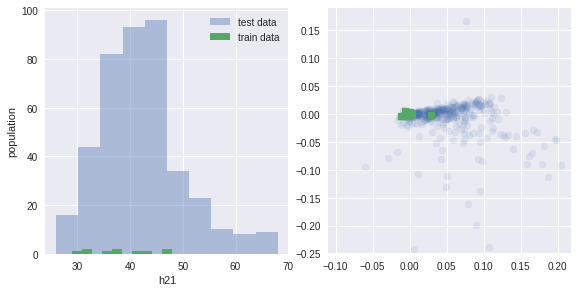

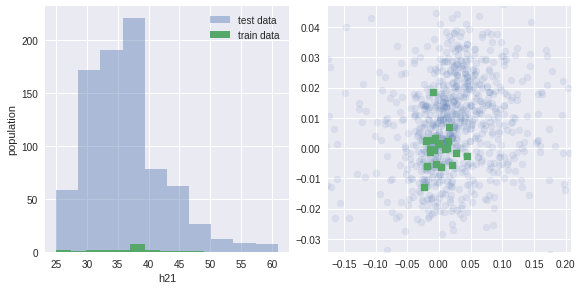

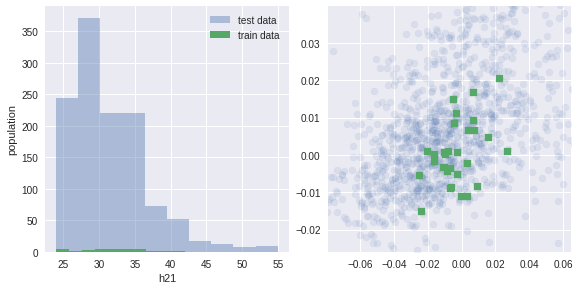

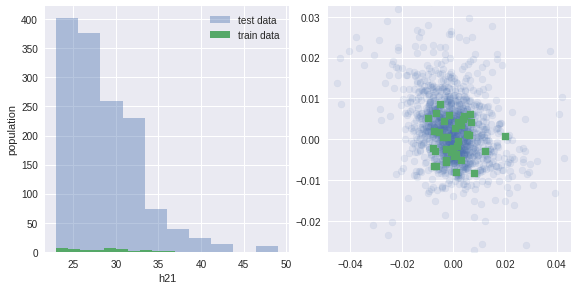

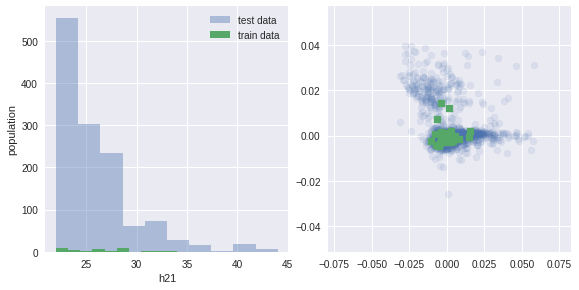

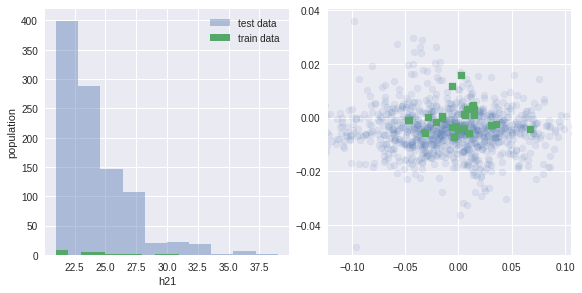

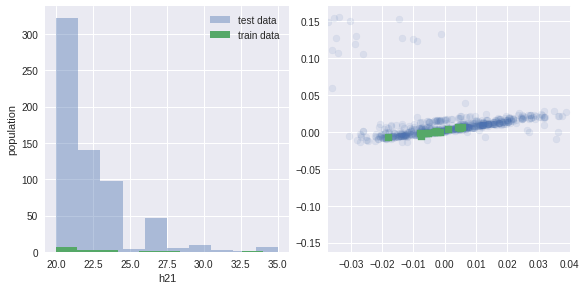

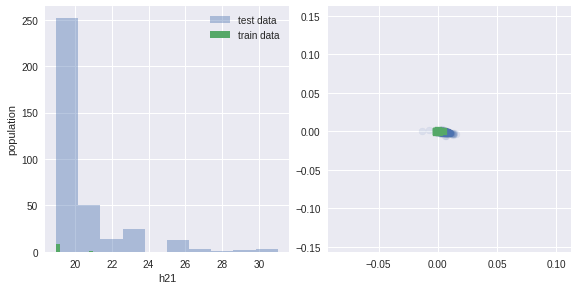

In [3]:
h11 = [4,5,6,7,8,9,10,11] # the h11 values for which we do the clustering

for h in h11:
    x_tr_h11, y_tr_h11, y_tr_h21 = get_h11_subset(x_train,y_train,y_h21_train,h)
    x_te_h11, y_te_h11, y_te_h21 = get_h11_subset(x_test,y_test,y_h21_test,h)
    traincloud, testcloud = [x_tr_h11,None],[x_te_h11,None]
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,4))
    f.tight_layout()
    create_histogram(ax1, y_te_h21,y_tr_h21)
    project_and_plt(ax2, traincloud, testcloud)
    plt.show()

## Choosing an optimal number of clusters within each scatter plot.

Since we have scatterplots of points all of which are labelled by the _same_ $h^{1,1}$ we analyze the scatterplots by means of unsupervised algorithms.

We choose K-means for definiteness. This algorithm works best when the clusters are approximately spherical. 

On the flip side, a bonus of using this algorithm is that it contains within itself an explicit definition of typicality, which is close to the intuitive
one outlined above. 

Namely, points closer to centroids are typical, while points far away from centroids are outliers.

We fix the optimal number of clusters by searching for the $k$ value which maximizes the silhouette score, and at which the inertia has an elbow.

Hodge number: 4


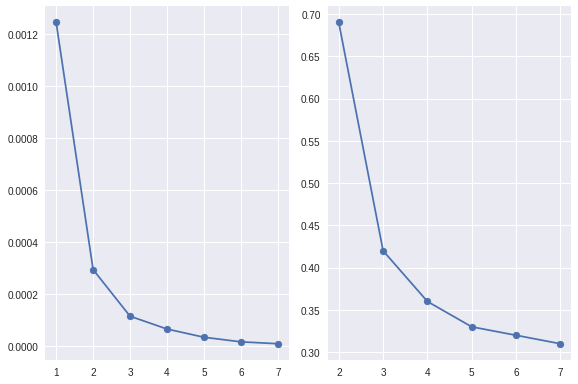

Hodge number: 5


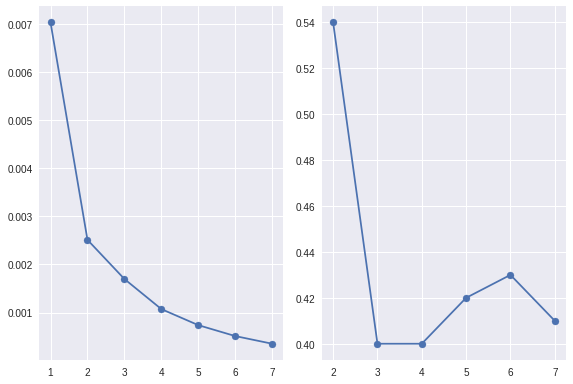

Hodge number: 6


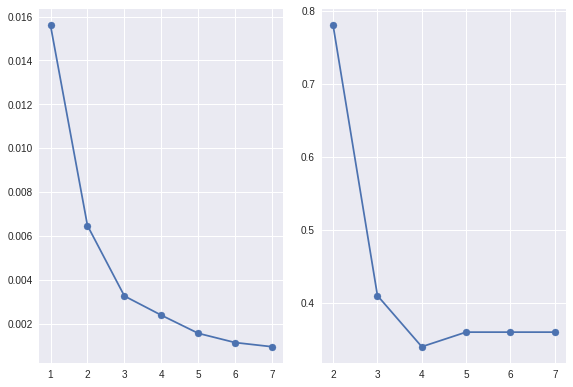

Hodge number: 7


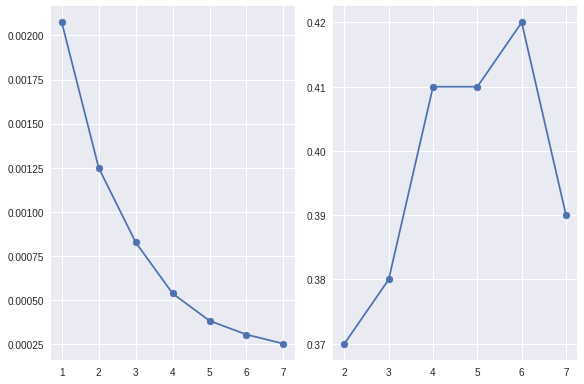

Hodge number: 8


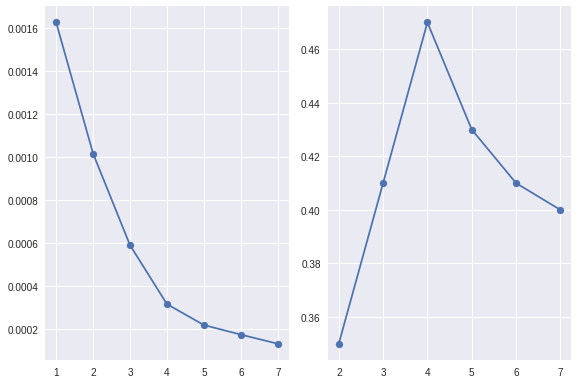

Hodge number: 9


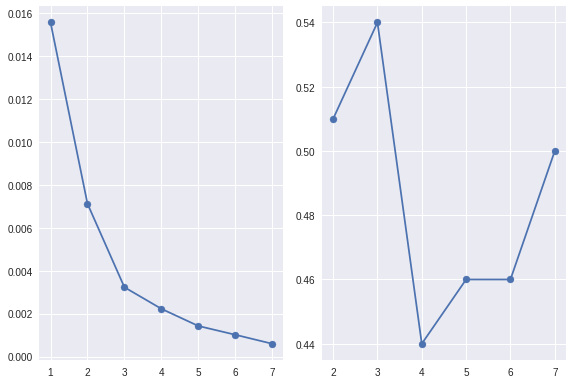

Hodge number: 10


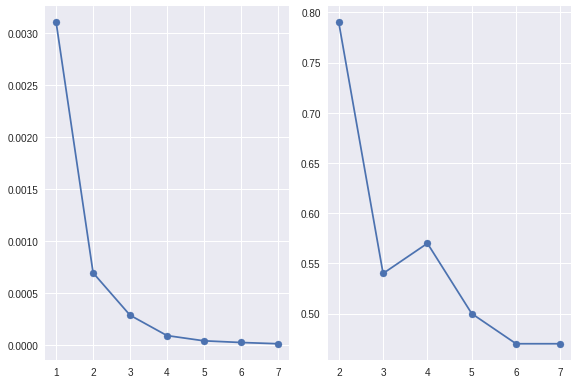

Hodge number: 11


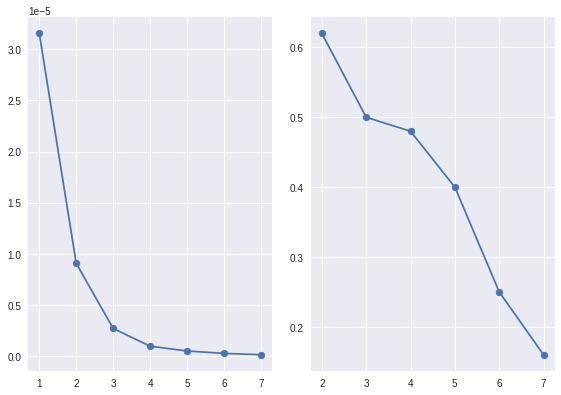

In [8]:
h11 = [4,5,6,7,8,9,10,11] # the h11 values for which we do the clustering
for h in h11:
    x_tr_h11, _, _ = get_h11_subset(x_train,y_train,y_h21_train,h)
    inertia, silhouette = [],[]
    k_ub = min(len(x_tr_h11),8)
    k_range = list(range(1,k_ub))
    for k in k_range:
        iner,sil = get_kmeans_scores(x_tr_h11,k)
        inertia.append(iner)
        if k >=2:
            silhouette.append(sil)
    plot_kmeans_scores(inertia,silhouette,k_range,h)

## Analyzing clusters

We now choose the optimal $k$ values and extract the points closest to the centroids. These are the manifolds
which might be regarded as being typical of the cluster.

Here we have plotted the scatter plots color coded by the cluster value assigned to them by K-means.

In [5]:
k_best = [2,2,2,6,4,3,2,2]

colormask = dict({0:'b',1:'g',2:'r',3:'brown',4:'orange',5:'black'})

colorize = lambda y_arr : [colormask[y] for y in y_arr]

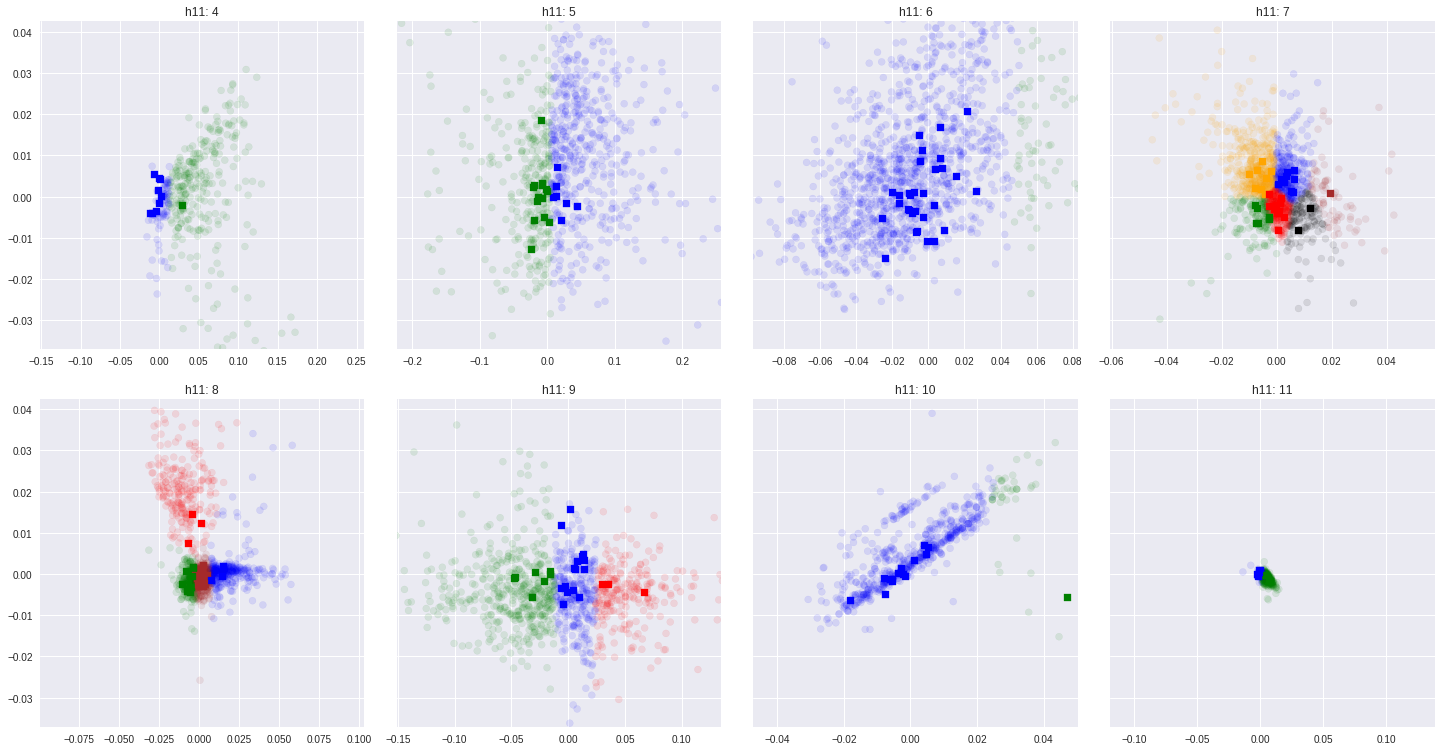

In [6]:
num_figs = 4

f, axes = plt.subplots(2, num_figs, sharey=True, figsize=(25,10))

outlier_reject = [(2.5,0.5)]*len(h11)

h21_typical = []
h21_mean, h21_std = [], []
h21_min, h21_max = [], []

df = pd.DataFrame(columns=['h11','h21 min', 
                           'h21 max', 'h21 mean', 'h21 std', 'typical h21'])

for ax,k,h,reject in zip(axes.flatten(),k_best,h11,outlier_reject):
    x_tr_h11, _, h21_train = get_h11_subset(x_train,y_train,y_h21_train,h)
    x_te_h11, _, h21_test = get_h11_subset(x_test,y_test,y_h21_test,h)
    kmeans = KMeans(n_clusters=k)
    y_pred_tr,y_pred_te,centroid_dist = kmeans_results(kmeans,x_tr_h11,x_te_h11)
    idx_representatives = np.argmin(centroid_dist,axis=0)
    row_append = [h]+h21_statistics(h21_train,h21_test,idx_representatives)
    df.loc[len(df)] = row_append
    color_tr = colorize(y_pred_tr) # color code clusters
    color_te = colorize(y_pred_te) # color code clusters
    project_and_plt(ax,[x_tr_h11,color_tr],[x_te_h11,color_te],reject)
    ax.set_title(f'h11: {h}')
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.15, wspace=0.1)
plt.show()

In [7]:
print('TYPICAL h21:')
print(df.to_markdown(tablefmt='grid',index=False))

TYPICAL h21:
+-------+-----------+-----------+------------+-----------+---------------------+
|   h11 |   h21 min |   h21 max |   h21 mean |   h21 std | typical h21         |
+=======+===========+===========+============+===========+=====================+
|     4 |        26 |        68 |    42.0753 |   7.6527  | [44 44]             |
+-------+-----------+-----------+------------+-----------+---------------------+
|     5 |        25 |        61 |    36.118  |   6.22636 | [38 27]             |
+-------+-----------+-----------+------------+-----------+---------------------+
|     6 |        24 |        55 |    31.7478 |   5.28587 | [30 39]             |
+-------+-----------+-----------+------------+-----------+---------------------+
|     7 |        23 |        49 |    28.447  |   4.41132 | [24 25 31 29 31 23] |
+-------+-----------+-----------+------------+-----------+---------------------+
|     8 |        22 |        44 |    25.9443 |   3.76892 | [23 28 31 22]       |
+-------+------

## Conclusion

We see that the typical manifolds that are identified by our algorithm have $h^{2,1}$ that are mostly within $\bar{h}^{2,1}\pm \sigma_{h_{21}}$.

We may therefore conclude that the manifolds identified by the algorithm are indeed typical of the corresponding $h^{1,1}$ clusters.